# Introduction and Schema Diagram
![Schema](schema.png)





# Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#returns a table
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql_query(q,conn)

#used to create tables and views
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
#display list of tables and views in our DB
def show_tables():
    q = '''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Albums to Purchase
write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

In [3]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
    (
     SELECT   
        il.track_id
     FROM customer c
     INNER JOIN invoice i ON c.customer_id = i.customer_id
     INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
     WHERE c.country = 'USA'    
    )
SELECT 
    g.name genre,
    COUNT(uts.track_id) tracks_sold,
    CAST(COUNT(uts.track_id) AS Float)/
    (SELECT COUNT(*) FROM usa_tracks_sold) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


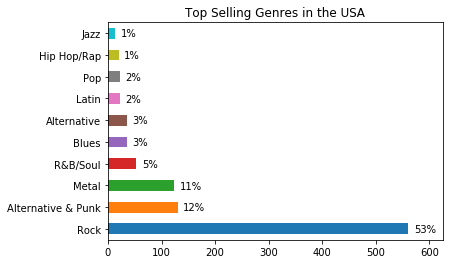

In [4]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index('genre',inplace=True,drop=True)
genre_sales_usa['tracks_sold'].plot.barh()
plt.title('Top Selling Genres in the USA')
plt.ylabel('')
plt.xlim(0,625)

for i,label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label]['tracks_sold']
    percent = genre_sales_usa.loc[label]['percentage_sold'] * 100
    percent = str(int(percent)) + "%"
    plt.annotate(percent ,(score+10, i-0.15))

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

# Analyzing Employee Sales Performance
Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.

In [5]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT 
         i.invoice_id,
         c.customer_id,
         c.support_rep_id,
         i.total
     FROM customer c
     INNER JOIN invoice i ON c.customer_id = i.customer_id
    )
    
SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(total) total_sales
FROM employee e
INNER JOIN customer_support_rep_sales csrs 
ON e.employee_id = csrs.support_rep_id
GROUP BY 1,2
'''
run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


Text(0.5,1,'Sales Breakdown by Employee')

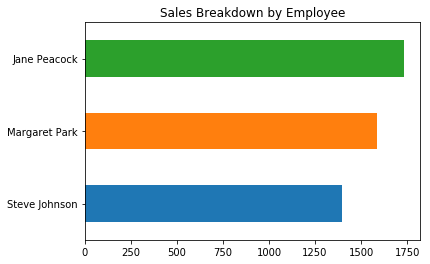

In [6]:
employee_sales = run_query(employee_sales_performance)
employee_sales.sort_values('total_sales',inplace=True)
employee_sales.plot.barh(x='employee',y='total_sales',legend=False)
plt.ylabel('')
plt.title('Sales Breakdown by Employee')

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

# Analyzing Sales by Country

In [7]:
sales_by_country = '''
WITH 
    country_stats AS
    (
    SELECT
        c.country,
        COUNT(distinct c.customer_id) customers,
        SUM(i.total) total_sales,
        AVG(i.total) average_order,
        SUM(i.total)/
        COUNT(distinct c.customer_id) customer_lifetime_value
    FROM invoice i
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1
    ),
    country_info AS
    (
    SELECT 
        CASE
            WHEN customers = 1 THEN 'Other'
            ELSE country
            END AS country,
        CASE
            WHEN customers = 1 THEN 1
            ELSE 0
            END AS sort,
        customers,
        total_sales,
        average_order,
        customer_lifetime_value
    FROM country_stats
    ),
    sales_by_country AS
    (
    SELECT
        country,
        SUM(customers) customers,
        SUM(total_sales) total_sales,
        AVG(average_order) average_order,
        AVG(customer_lifetime_value) customer_lifetime_value
    FROM country_info
    GROUP BY 1
    ORDER BY sort ASC,total_sales DESC
    )
SELECT * FROM sales_by_country
'''
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.445071,72.996000


# Visualizing Sales by Country

# Albums vs Individual Tracks, Part 1

In [8]:
albums_vs_tracks = '''
WITH invoice_details AS
    (
    SELECT 
        i.invoice_id,
        SUM(il.track_id) tot_track_id
    FROM invoice i
    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
    GROUP BY 1
    ),
    album_details AS
    (
    SELECT 
        a.album_id,
        SUM(t.track_id) tot_track_id
    FROM album a
    INNER JOIN track t ON a.album_id = t.album_id
    GROUP BY 1
    ),
    album_invoice AS
    (
    SELECT
        i.invoice_id,
        a.album_id
    FROM invoice_details i
    INNER join album_details a ON i.tot_track_id = a.tot_track_id
    )
    
    
SELECT 
    COUNT(*) album_purchase,
    (CAST(COUNT(*) AS Float)/(SELECT COUNT(*) FROM invoice))*100 pct_album_purchase,                
    (SELECT COUNT(*) FROM invoice) - COUNT(*) non_album_purchase,
    (((SELECT COUNT(*) FROM invoice) - COUNT(*)) * 100.0)/(SELECT COUNT(*) FROM invoice) pct_non_album_purchase
FROM album_invoice
'''
run_query(albums_vs_tracks)


,album_purchase,pct_album_purchase,non_album_purchase,pct_non_album_purchase
0,119,19.381107,495,80.618893


Album purchases account for 20% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

# Tracks Sold vs Unsold


In [9]:
sold_vs_unsold = '''
WITH unsold AS
    (
    SELECT name FROM track
    EXCEPT 
    SELECT distinct t.name 
    FROM invoice_line il
    INNER JOIN track t ON il.track_id = t.track_id
    )
SELECT COUNT(*) unsold_tracks, (SELECT COUNT(*) FROM track) total_tracks  FROM unsold

'''
run_query(sold_vs_unsold)

,unsold_tracks,total_tracks
0,1523,3503


There are 1523 unsold tracks out of 3503 tracks available in the store. Thus only 57% of the tracks have been sold.

# Artist Sales Statistics

In [10]:
artist_sales_stats = '''
WITH track_info AS
    (
    SELECT
        t.track_id,
        t.name, 
        ar.name artist
    FROM track t
    INNER JOIN album al ON t.album_id = al.album_id
    INNER JOIN artist ar ON ar.artist_id = al.artist_id        
    ),
    artist_total_tracks AS
    (
    SELECT artist, COUNT(*) total_tracks
    FROM track_info
    GROUP BY 1
    ),
    artist_total_tracks_sold AS
    (
    SELECT artist,COUNT(distinct il.track_id) tracks_sold
    FROM invoice_line il 
    INNER JOIN track_info t ON il.track_id = t.track_id
    GROUP BY 1
    )
SELECT att.artist,total_tracks,tracks_sold, (tracks_sold*100)/total_tracks pct_sold      
FROM artist_total_tracks att
INNER JOIN artist_total_tracks_sold atts ON atts.artist = att.artist
ORDER BY 3 DESC
'''
run_query(artist_sales_stats)

,artist,total_tracks,tracks_sold,pct_sold
0,Iron Maiden,213,75,35
1,U2,135,73,54
2,Metallica,112,68,60
3,Pearl Jam,67,62,92
4,Led Zeppelin,114,53,46
5,Red Hot Chili Peppers,48,48,100
6,Van Halen,52,48,92
7,Queen,45,45,100
8,Foo Fighters,44,43,97
9,Guns N' Roses,42,42,100


# Finding out the Artists with MAX Number of Tracks in each Playlist

In [11]:
playlist_artist_max = '''
WITH playlist_artist AS
    (
    SELECT
        p.name playlist,
        ar.name artist,
        COUNT(t.name) tracks
    FROM track t
    INNER JOIN album al ON t.album_id = al.album_id
    INNER JOIN artist ar ON ar.artist_id = al.artist_id 
    INNER JOIN playlist_track pt ON pt.track_id = t.track_id
    INNER JOIN playlist p ON p.playlist_id = pt.playlist_id
    GROUP BY 1,2
    )
SELECT playlist, artist, MAX(tracks) tracks
FROM playlist_artist
GROUP BY 1
'''
run_query(playlist_artist_max)

,playlist,artist,tracks
0,90’s Music,Iron Maiden,84
1,Brazilian Music,Tim Maia,7
2,Classical,Berliner Philharmoniker & Herbert Von Karajan,3
3,Classical 101 - Deep Cuts,"Academy of St. Martin in the Fields, Sir Nevil...",1
4,Classical 101 - Next Steps,Berliner Philharmoniker & Herbert Von Karajan,2
5,Classical 101 - The Basics,Aaron Copland & London Symphony Orchestra,1
6,Grunge,Nirvana,6
7,Heavy Metal Classic,Iron Maiden,6
8,Music,Iron Maiden,426
9,Music Videos,Audioslave,1


# Which artist is used in the most playlists?

In [12]:
artist_most_playlist = '''
WITH artist_info AS
    (
    SELECT
        ar.name artist,
        COUNT(distinct p.name) playlist
    FROM track t
    INNER JOIN album al ON t.album_id = al.album_id
    INNER JOIN artist ar ON ar.artist_id = al.artist_id 
    INNER JOIN playlist_track pt ON pt.track_id = t.track_id
    INNER JOIN playlist p ON p.playlist_id = pt.playlist_id
    GROUP BY 1
    )
SELECT artist, MAX(playlist) playlist FROM artist_info
'''
run_query(artist_most_playlist)

,artist,playlist
0,Eugene Ormandy,6


Eugene Ormandy is used in 6 playlists

# Do protected vs non-protected media types have an effect on popularity?

In [13]:
media_type_sales = '''
with tracks_purchased AS
    (
    SELECT
        mt.name,
        COUNT(il.track_id) track_sales
    FROM invoice_line il
    INNER JOIN track t ON il.track_id = t.track_id
    INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
    GROUP BY 1
    )
SELECT * FROM tracks_purchased
'''
run_query(media_type_sales)

,name,track_sales
0,AAC audio file,21
1,MPEG audio file,4259
2,Protected AAC audio file,439
3,Protected MPEG-4 video file,3
4,Purchased AAC audio file,35


Non-protected files are much more popular then protected files